In [91]:
from scripts.dataset_builder import generate_dataset

dataset = generate_dataset(pca_components=30)

C:\Users\jackh\anaconda3\envs\Synther2\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jackh\anaconda3\envs\Synther2\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jackh\anaconda3\envs\Synther2\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is tryin

# Now try to predict the number of likes

In [92]:
dataset.keys()

dict_keys(['account_labels', 'meta_features', 'image_features', 'original_img_feats', 'likes'])

In [93]:
#dataset.keys() dict_keys(['account_labels', 'meta_features', 'image_features', 'likes'])
meta_features = dataset['meta_features']
meta_names = list(meta_features.columns)
meta_features = meta_features.to_numpy()

img_feats = dataset['image_features']
img_names = [f"Img{i}" for i in range(img_feats.shape[1])]
likes = dataset['likes']

og_feats = dataset['original_img_feats']
og_names =  [f"OG{i}" for i in range(og_feats.shape[1])]

import numpy as np
#feats = np.concatenate([meta_features, img_feats],axis=1)
feats = meta_features
feat_names = meta_names# meta_names + img_names

In [94]:
#Try Scaling the image features? Makes no difference
'''
from sklearn.preprocessing import StandardScaler

for i in range(feats.shape[1]):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(feats[:,i].reshape(-1,1))
    feats[:,i] = scaled_data.reshape(-1)
'''


'\nfrom sklearn.preprocessing import StandardScaler\n\nfor i in range(feats.shape[1]):\n    scaler = StandardScaler()\n    scaled_data = scaler.fit_transform(feats[:,i].reshape(-1,1))\n    feats[:,i] = scaled_data.reshape(-1)\n'

In [95]:
from sklearn.model_selection import train_test_split
indic = [i for i in range(len(feats))]

train_indic, test_indic = train_test_split(indic, test_size=0.25, random_state=22)
train_x, train_y = feats[train_indic], likes[train_indic]
test_x, test_y = feats[test_indic], likes[test_indic]


In [96]:
# check xgboost version
import xgboost as xg

# create an xgboost regression model
model = xg.XGBRegressor(n_estimators=200,max_depth=5, objective='reg:tweedie')

In [97]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import numpy as np

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)
# evaluate model
scores = cross_val_score(model, train_x, train_y, scoring='neg_mean_absolute_error', cv=cv)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )


Mean MAE: 25.641 (9.727)


In [98]:
# Mean MAE: 31.924 (11.347) , using all features
#Mean MAE: 27.490 (4.751) using just metadata
#Using just images, Mean MAE: 47.835 (13.093)
#Mean MAE: 54.478 (14.481) , using original features

#Repeating:

#Mean MAE: 33.829 (11.728) , using all features - abs err 2418.56916937232
#Mean MAE: 40.391 (11.775) , using 30 pca features - abs err 3381.050395011902
#Mean MAE: 29.821 (12.454) , using just metadata - abs err 2692.2402110099792
#Mean MAE: 49.342 (15.223) , using og features - abs err 3609.9505043029785

#Using tweedie loss:        IS IT JUST USING A DIFFERENT LOSS?
#Mean MAE: 25.886 (10.592) , using all features and tweedie loss - abs err 2433.537032842636
#Mean MAE: 30.734 (10.233), using 30 features and tweedie loss - abs err 3092.4900805950165
#Mean MAE: 25.641 (9.727) , using just metadata and tweedie loss - abs err 2636.135491132736
#Mean MAE: 35.212 (10.327), using og features - abs err 3414.4119408130646

In [99]:
import pandas as pd
model.fit(train_x, train_y)
pred_y = model.predict(test_x)
results = pd.DataFrame([pred_y, test_y])

Feature: following, Score: 0.04124711826443672
Feature: posts_count, Score: 0.08092392981052399
Feature: followers, Score: 0.41367727518081665
Feature: is_verified, Score: 0.20178662240505219
Feature: adultScore, Score: 0.02232075296342373
Feature: racyScore, Score: 0.02423613704741001
Feature: goreScore, Score: 0.02995418757200241
Feature: isBWImg, Score: 0.03173229470849037
Feature: clipArtType, Score: 0.054418403655290604
Feature: lineDrawingType, Score: 0.009904148057103157
Feature: weekday, Score: 0.08979911357164383


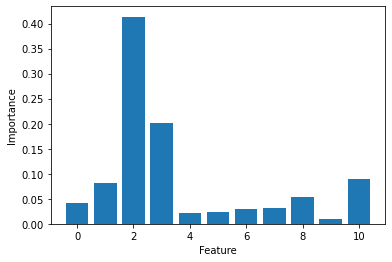

In [100]:
%matplotlib inline 

import matplotlib.pyplot as plt
# get importance

importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: {feat_names[i]}, Score: {v}')
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Feature')
plt.ylabel('Importance')
#plt.savefig('plots/feature_importance_30features_XGBoost_0911.png')
plt.show()

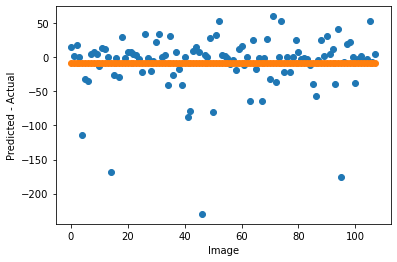

In [101]:
%matplotlib inline

delta = np.subtract(pred_y, test_y.reshape(test_y.shape[0]))
import matplotlib.pyplot as plt
plt.scatter([i for i in range(len(delta))], delta)
plt.scatter([i for i in range(len(delta))], [delta.mean() for i in range(len(delta))])
plt.xlabel('Image')
plt.ylabel('Predicted - Actual')
#plt.savefig('plots/XGBoost_test_DeltaLikes_0711.png')
plt.show()

In [109]:
np.abs(delta).mean()

24.408661954932743

In [103]:
delta_thresh = 750
bad_pred_index = list(np.where(np.abs(delta) > 750)[0])
if len(bad_pred_index) > 0:
    bad_posts = np.array(test_indic)[bad_pred_index]
    print(bad_posts)

    bad_post_url = dataset['account_labels'].iloc[bad_posts]['image_url']
    print(bad_post_url.iloc[0])

    from IPython.display import Image
    Image(filename=f'data/images/{bad_post_url.iloc[0]}') 

In [104]:
test_pred = pred_y[np.where(np.abs(delta) < delta_thresh)]
test_true = test_y[np.where(np.abs(delta) < delta_thresh)]

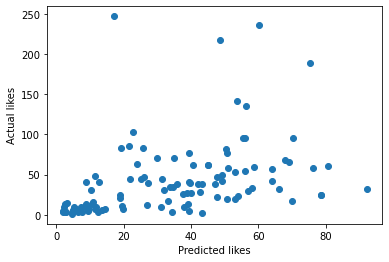

In [105]:
%matplotlib inline 
import matplotlib.pyplot as plt 
plt.scatter(test_pred, test_true)
plt.xlabel('Predicted likes')
plt.ylabel('Actual likes')
plt.show()

In [106]:
best_feature = feats[:, np.argmax(importance)]

In [107]:
best_feature.shape

(432,)

(array([319.,  35.,  24.,  20.,  21.,   0.,   0.,   1.,  10.,   2.]),
 array([-0.74110334, -0.1538659 ,  0.43337155,  1.02060899,  1.60784643,
         2.19508388,  2.78232132,  3.36955876,  3.95679621,  4.54403365,
         5.13127109]),
 <BarContainer object of 10 artists>)

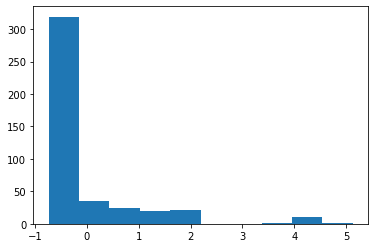

In [108]:
%matplotlib inline
plt.hist(best_feature)